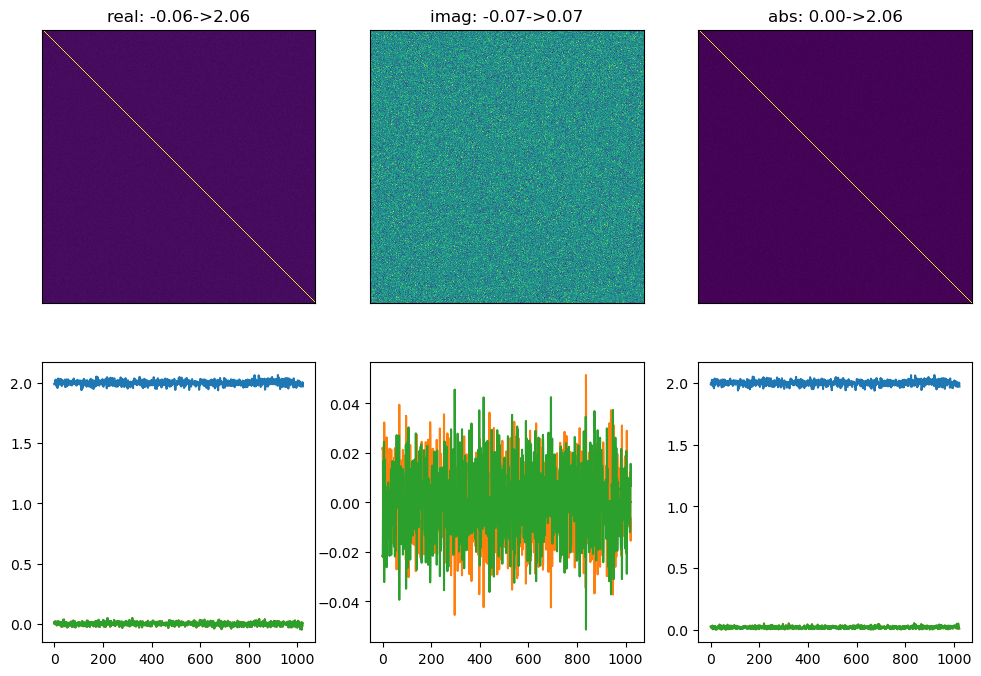

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

npoints = 1024
nsamples = 10000
rng = np.random.default_rng()
original_noise = rng.standard_normal((npoints, nsamples)) + 1j * rng.standard_normal((npoints, nsamples))

original_cov = np.cov(original_noise)

def plot_cov(cov_mat: np.ndarray) -> plt.Figure:
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes[0, 0].matshow(np.real(cov_mat))
    axes[0, 1].matshow(np.imag(cov_mat))
    axes[0, 2].matshow(np.abs(cov_mat))
    for ax in axes[0]:
        ax.set_xticks([])
        ax.set_yticks([])

    for idx, name in enumerate([
            ('real', np.real), 
            ('imag', np.imag),
            ('abs', np.abs)]):
        axes[0, idx].set_title(f'{name[0]}: {np.min(name[1](cov_mat)):0.2f}->{np.max(name[1](cov_mat)):0.2f}')

        for k, alpha in zip()
        axes[1, 0].plot(np.diag(np.real(cov_mat)))
    axes[1, 0].plot(np.diag(np.real(cov_mat), k=1))
    axes[1, 0].plot(np.diag(np.real(cov_mat), k=-1))
    axes[1, 1].plot(np.diag(np.imag(cov_mat)))
    axes[1, 1].plot(np.diag(np.imag(cov_mat), k=1))
    axes[1, 1].plot(np.diag(np.imag(cov_mat), k=-1))
    axes[1, 2].plot(np.diag(np.abs(cov_mat)))
    axes[1, 2].plot(np.diag(np.abs(cov_mat), k=1))
    axes[1, 2].plot(np.diag(np.abs(cov_mat), k=-1))
    plt.show()
    return fig

fig = plot_cov(original_cov)

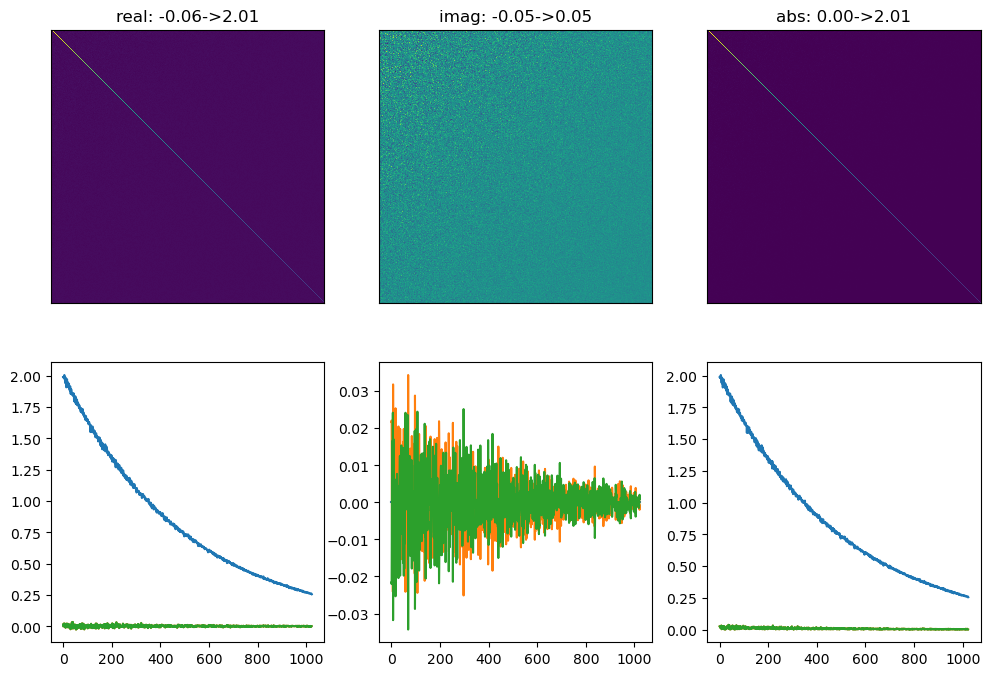

In [63]:
def apod_window(size: int, dwelltime: float, broadening: float) -> np.ndarray:
    taxis = np.linspace(0, dwelltime * (size - 1), size)
    Tl = 1 / broadening
    return np.exp(-taxis / Tl)

def apodise(data: np.ndarray, dwelltime: float, broadening: float) -> np.ndarray:
    window = apod_window(data.shape[0], dwelltime, broadening)
    return window[:, np.newaxis] * data

apodised_noise = apodise(original_noise, 1, 0.001)

apodised_cov = np.cov(apodised_noise)

fig = plot_cov(apodised_cov)

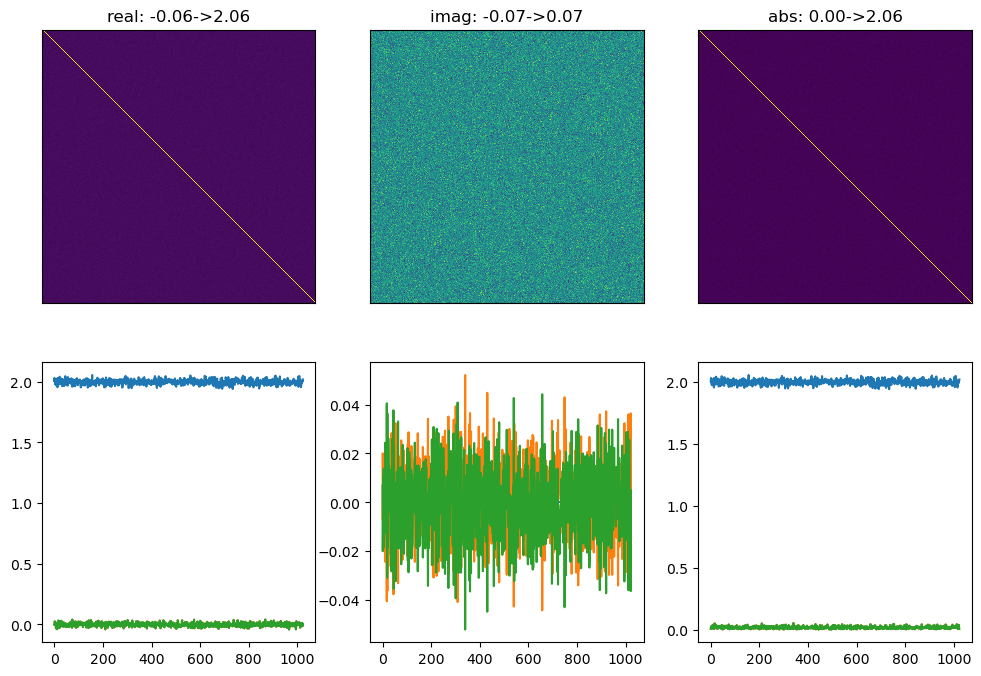

In [58]:
from fsl_mrs.utils.misc import FIDToSpec
fft_noise = FIDToSpec(original_noise, axis=0)
fft_cov = np.cov(fft_noise)

fig = plot_cov(fft_cov)

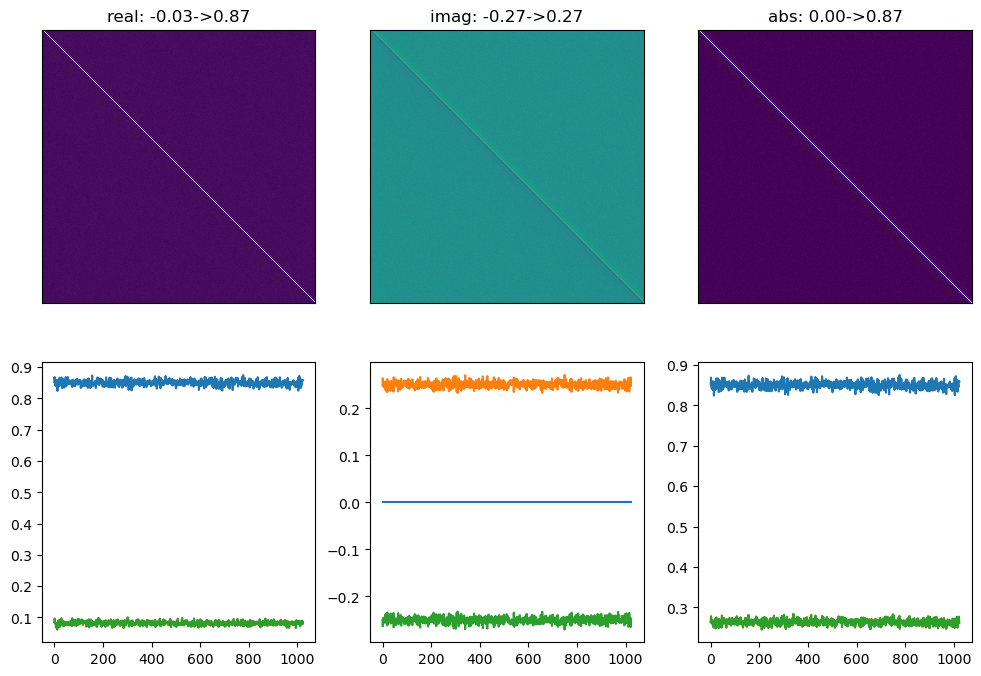

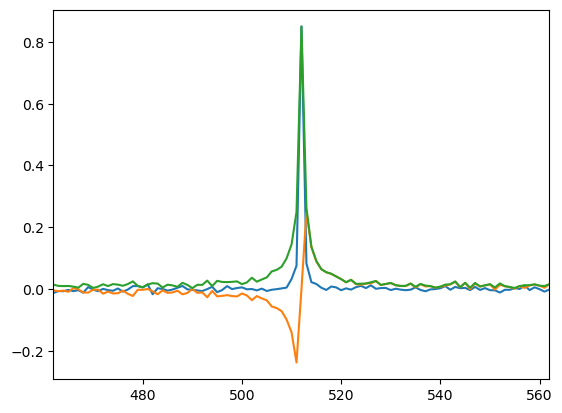

In [101]:
fft_apod_noise = FIDToSpec(apodised_noise, axis=0)
fft_apod_cov = np.cov(fft_apod_noise)

fig = plot_cov(fft_apod_cov)

plt.plot(fft_apod_cov.real[512,:])
plt.plot(fft_apod_cov.imag[512,:])
plt.plot(np.abs(fft_apod_cov)[512,:])
plt.xlim([512-50, 512+50])
plt.show()

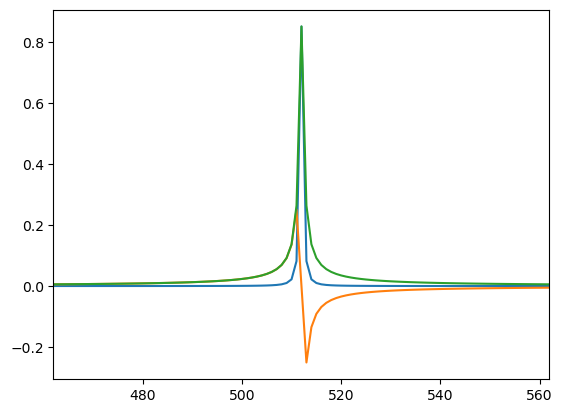

In [102]:
noise_sd = 1
complex_noise_sd = np.sqrt(noise_sd + noise_sd)
window = apod_window(npoints, 1, 0.001)
fft_ortho_scale_factor = 1 / np.sqrt(npoints)
scaled_fft_window = FIDToSpec(window ** 2) * complex_noise_sd**2 * fft_ortho_scale_factor
plt.plot(scaled_fft_window.real)
plt.plot(scaled_fft_window.imag)
plt.plot(np.abs(scaled_fft_window))
plt.xlim([512-50, 512+50])
plt.show()

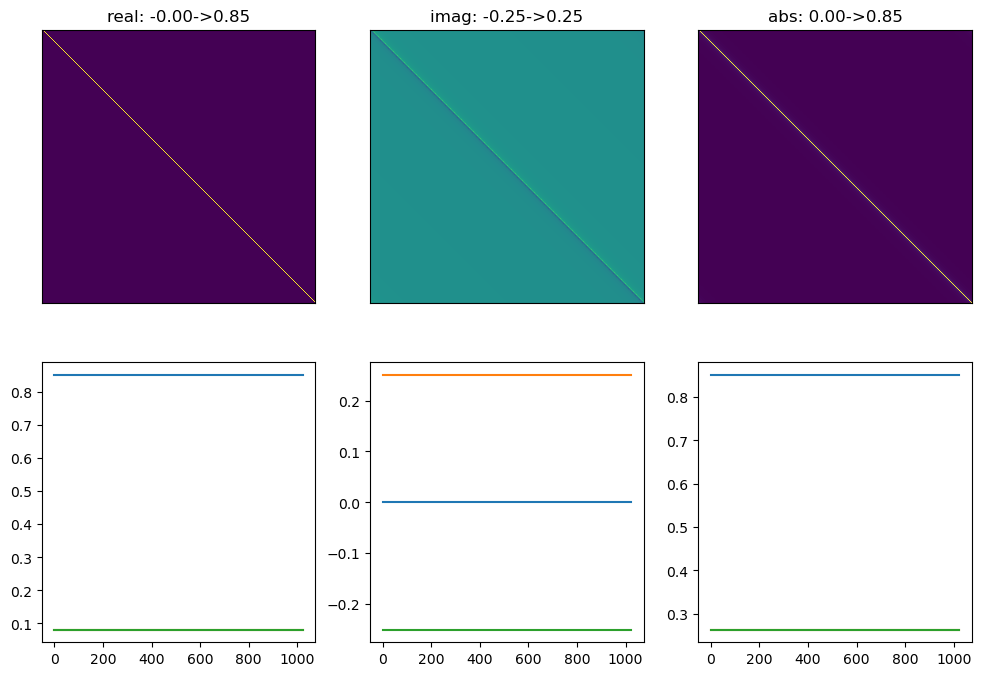

In [114]:
from scipy.linalg import circulant
def make_windowed_cov(window: np.array, noise_sd: float) -> np.ndarray:
    complex_noise_sd = np.sqrt(noise_sd + noise_sd)
    fft_ortho_scale_factor = 1 / np.sqrt(window.size)
    scaled_fft_window = FIDToSpec(window ** 2) * complex_noise_sd ** 2 * fft_ortho_scale_factor
    return circulant(np.fft.fftshift(scaled_fft_window))
direct_cov = make_windowed_cov(
    apod_window(npoints, 1, 0.001),
    noise_sd
)
fig = plot_cov(direct_cov)

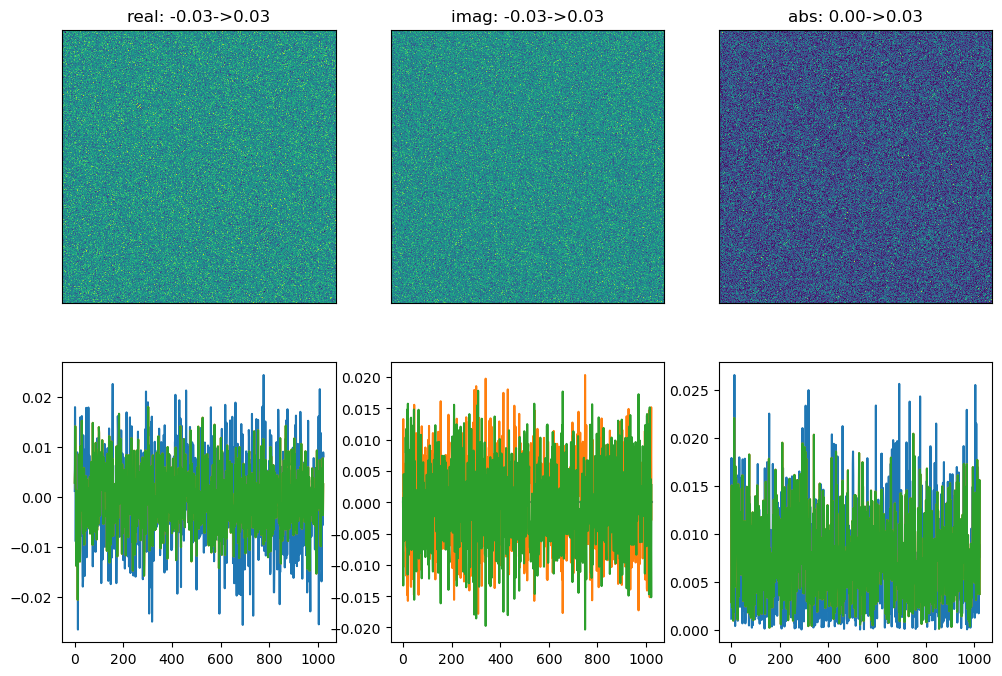

In [115]:
fig = plot_cov(fft_apod_cov-direct_cov)